# Test 2022 Radar Datasets

This notebook tests read enhancements to the ```er2``` module and added resampling and ice attenuation correction functionality.

- Added an optional ```dataset``` input argument to the ```readfile()``` routines as the 2022 hdf files have subtle changes to metadata keys. 
- ```er2.Hiwrap.readfile()``` requires a tuple of 2 files (Ku then Ka) as the datasets were split for the 2022 deployment.  
- The ```resample()``` routine is only supported for CRS and EXRAD since it's temporal sampling (4 Hz) is finer than HIWRAP (2 Hz).  
- The ```ice_attenuation()``` routine is only supported for CRS since it's negligable for the other frequencies.

In [1]:
import sys
sys.path.append('../github/impacts_tools/src')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from impacts_tools import er2, radar_cmaps

%matplotlib inline

Simple routine to create an extra element in time and range dims for ```pcolormesh()```

In [2]:
def xsection_grid(x_grid, y_grid):
    '''
    Adds an extra element in the time/distance and height dimension to conform to newer mpl pcolormesh() function.
    Useful for plotting ER-2 radar cross sections.
    
    Parameters
    ----------
    x_grid: 2D time or distance field created from er2read() or resample() subroutines.
    y_grid: 2D height field created from er2read() or resample() subroutines.
    '''
    
    # Work with x coordinate (time/distance) first
    xdelta = x_grid[0, -1] - x_grid[0, -2] # should work on time and float dtypes
    vals_to_append = np.atleast_2d(np.tile(x_grid[0,-1] + xdelta, x_grid.shape[0])).T
    x_regrid = np.hstack((x_grid, vals_to_append)) # add column
    x_regrid = np.vstack((np.atleast_2d(x_regrid[0,:]), x_regrid)) # add row
    
    # Now do the y coordinate (height)
    ydelta = y_grid[0, :] - y_grid[1, :] # height difference between first and second gates
    vals_to_append = np.atleast_2d(y_grid[0,:] + ydelta)
    y_regrid = np.vstack((vals_to_append, y_grid)) # add row
    y_regrid = np.hstack((y_regrid, np.atleast_2d(y_regrid[:,-1]).T))
    
    return x_regrid, y_regrid

## Test 2020 Data

Look at the 1556-1613 UTC 07 Feb flight leg for HIWRAP and ensure no bugs in the code.

In [3]:
fname = (
    'IMPACTS2020_HIWRAP_L1B_RevC_20200207.h5'
)
start = np.datetime64('2020-02-07T15:56:00')
end = np.datetime64('2020-02-07T16:13:00')
hiwrap = er2.Hiwrap(fname, start_time=start, end_time=end, dbz_sigma=1)
hiwrap.data

<xarray.Dataset>
Dimensions:                   (range: 609, time: 2041)
Coordinates:
  * range                     (range) float32 5.014e+03 5.04e+03 ... 2.097e+04
    height                    (range, time) float32 1.472e+04 ... -1.155e+03
  * time                      (time) datetime64[ns] 2020-02-07T15:56:00 ... 2...
    distance                  (time) float32 2.717e+06 2.718e+06 ... 2.949e+06
    lat                       (time) float32 43.13 43.13 43.13 ... 43.05 43.05
    lon                       (time) float32 -76.28 -76.28 ... -73.44 -73.44
Data variables: (12/28)
    dbz_ka                    (range, time) float32 nan nan nan ... nan nan nan
    dbz_ku                    (range, time) float32 nan nan nan ... 10.08 10.57
    vel_ka                    (range, time) float32 nan nan nan ... nan nan nan
    vel_ku                    (range, time) float32 nan nan nan ... nan nan nan
    width_ka                  (range, time) float32 nan nan nan ... nan nan nan
    width_ku                  (range, time) float32 nan nan nan ... 3.315 3.379
    ...                        ...
    er2_drift                 (time) float32 -0.6908 -0.7 -0.7 ... -0.7 -0.7
    er2_EastVel               (time) float32 230.4 230.4 230.4 ... 226.9 226.9
    er2_NorthVel              (time) float32 -7.642 -7.642 ... -13.48 -13.48
    er2_upVel                 (time) float32 0.8855 1.158 ... 0.3025 0.3309
    er2_track                 (time) float32 91.9 91.9 91.9 ... 93.4 93.4 93.4
    er2_motion                (time) float32 0.6795 0.7486 ... 0.6321 0.6231
Attributes: (12/24)
    Experiment:                                       IMPACTS2020_Ku
    Date:                                             20200207
    Aircraft:                                         NASA ER-2
    Radar Name:                                       HIWRAP
    Data Contact:                                     Matthew L. Walker McLin...
    Instrument PI:                                    Lihua Li, NASA/GSFC
    ...                                               ...
    Radar Transmit Ka-Band Wavelength (m):            [0.00843645]
    Radar Transmit Ku-Band Wavelength (m):            [0.02156722]
    Range Gate Spacing (m):                           26.25
    Nominal Antenna Pointing:                         Nadir
    PRI:                                              224 us / 280 us staggered
    Bands:                                            Ka, Ku

Plot the Z$_{Ku}$, Z$_{Ka}$, and DFR$_{Ku-Ka}$

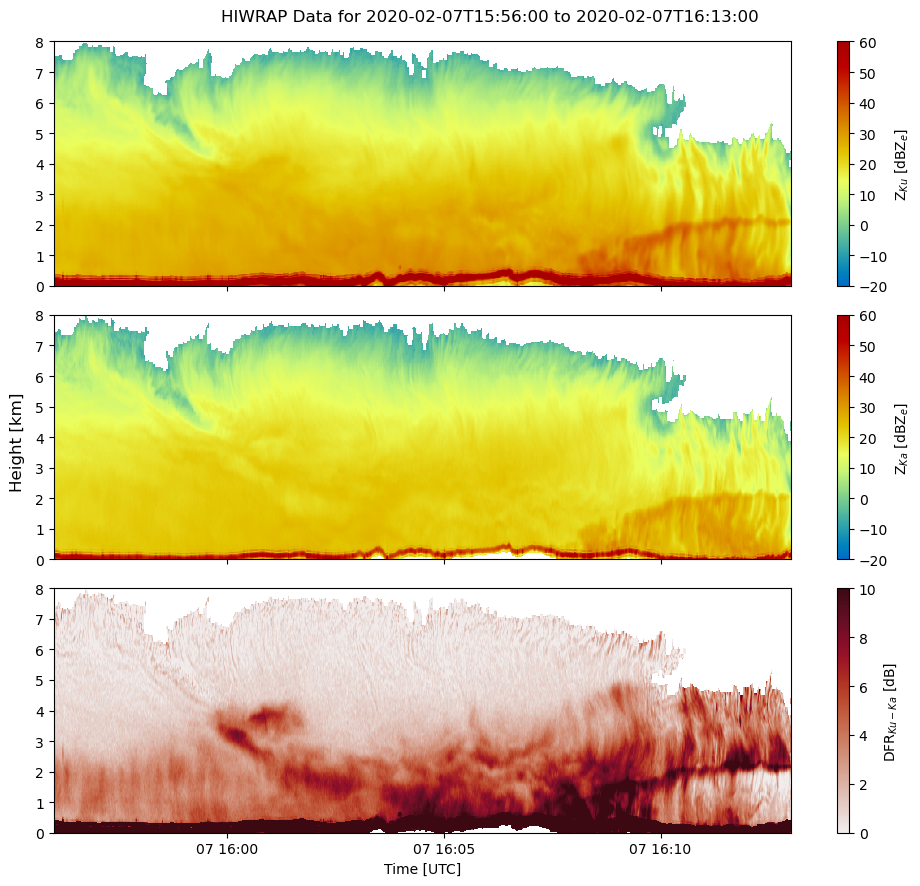

In [4]:
fig, axs = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(10,9))
cmap_balance = plt.get_cmap('radar_balance')
cmap_db = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(
            n=cmap_balance.name, a=0.5, b=1.),
    cmap_balance(np.linspace(0.5, 1., 100)
        )
) # for DFR cmap without blue shades

# Z_Ku
ax = axs[0]
plt1 = ax.pcolormesh(
    hiwrap.data['time'][:], hiwrap.data['height'][:, 0] / 1000,
    hiwrap.data['dbz_ku'], vmin=-20, vmax=60,
    shading='nearest', cmap='radar_HomeyerRainbow', rasterized=True
)
cb = fig.colorbar(plt1, ax=ax)
cb.set_label('Z$_{Ku}$ [dBZ$_e$]')

# Z_Ka
ax = axs[1]
plt2 = ax.pcolormesh(
    hiwrap.data['time'][:], hiwrap.data['height'][:, 0] / 1000,
    hiwrap.data['dbz_ka'], vmin=-20, vmax=60,
    shading='nearest', cmap='radar_HomeyerRainbow', rasterized=True
)
cb = fig.colorbar(plt2, ax=ax)
cb.set_label('Z$_{Ka}$ [dBZ$_e$]')

# DFR
ax = axs[2]
plt3 = ax.pcolormesh(
    hiwrap.data['time'][:], hiwrap.data['height'][:, 0] / 1000,
    hiwrap.data['dbz_ku'] - hiwrap.data['dbz_ka'],
    vmin=0., vmax=10, shading='nearest', cmap=cmap_db,
    rasterized=True
)
cb = fig.colorbar(plt3, ax=ax)
cb.set_label('DFR$_{Ku-Ka}$ [dB]')

plt.suptitle(f'HIWRAP Data for {str(start)} to {str(end)}')
fig.supylabel('Height [km]')
plt.xlabel('Time [UTC]')
plt.ylim(0, 8)

plt.tight_layout()
plt.show()

## Test 2022 Data

- Look at the 1440-1455 UTC 19 Jan flight leg for HIWRAP and ensure no bugs in the code.  
- Also test ```resample()``` and ```ice_attenuation()``` routines on CRS data.

First load the HIWRAP data and view the dataset structure.

In [5]:
fname_hiwrap = (
    'IMPACTS2022_HIWRAP_KU_L1B_Rev-_20220119.h5',
    'IMPACTS2022_HIWRAP_KA_L1B_Rev-_20220119.h5'
) # note the 2-element tuple of filenames (Ku then Ka)
fname_hrrr_hiwrap = (
    'hrrr.hiwrap_grid.20220119.nc'
)
start = np.datetime64('2022-01-19T14:40:00')
end = np.datetime64('2022-01-19T14:55:00')
hiwrap = er2.Hiwrap(
    fname_hiwrap, start_time=start, end_time=end, atten_file=fname_hrrr_hiwrap,
    dataset='2022', dbz_sigma=1
) # note the 2022 dataset argument
hiwrap.data

<xarray.Dataset>
Dimensions:                   (range: 609, time: 1801)
Coordinates:
  * range                     (range) float64 5.014e+03 5.04e+03 ... 2.097e+04
    height                    (range, time) float64 1.453e+04 ... -1.511e+03
  * time                      (time) datetime64[ns] 2022-01-19T14:40:00 ... 2...
    distance                  (time) float32 2.606e+06 2.606e+06 ... 2.77e+06
    lat                       (time) float64 45.33 45.33 45.33 ... 46.32 46.31
    lon                       (time) float64 -72.33 -72.32 ... -73.51 -73.51
Data variables: (12/28)
    dbz_ka                    (range, time) float32 nan nan nan ... nan nan nan
    dbz_ku                    (range, time) float32 nan nan nan ... 23.55 24.23
    vel_ka                    (range, time) float64 nan nan nan ... nan nan nan
    vel_ku                    (range, time) float64 nan nan nan ... nan nan nan
    width_ka                  (range, time) float64 nan nan nan ... nan nan nan
    width_ku                  (range, time) float64 nan nan nan ... 2.925 2.756
    ...                        ...
    er2_drift                 (time) float64 2.4 2.489 2.5 ... -5.6 -5.7 -5.8
    er2_EastVel               (time) float64 160.8 159.2 157.5 ... -72.5 -70.87
    er2_NorthVel              (time) float64 143.7 145.4 147.2 ... -164.3 -165.2
    er2_upVel                 (time) float64 -1.617 -1.675 ... -0.741 -0.8831
    er2_track                 (time) float64 48.22 47.61 46.93 ... 203.8 203.2
    er2_motion                (time) float32 8.912 9.171 9.366 ... -1.585 -1.775
Attributes: (12/24)
    Experiment:                                       IMPACTS2022
    Date:                                             20220119
    Aircraft:                                         ER-2
    Radar Name:                                       HIWRAP_KU
    Data Contact:                                     Matthew L. Walker McLin...
    Instrument PI:                                    Lihua Li, NASA/GSFC
    ...                                               ...
    Radar Transmit Ka-Band Wavelength (m):            0.00843644544431946
    Radar Transmit Ku-Band Wavelength (m):            0.021567217828900073
    Range Gate Spacing (m):                           26.25
    Nominal Antenna Pointing:                         Nadir
    PRI:                                              224 us / 280 us staggered
    Bands:                                            Ka, Ku

Load the (ice attenuated) CRS data and resample to the HIWRAP time-range grid.

In [6]:
fname_crs = (
    'IMPACTS2022_CRS_L1B_Rev-_20220119.h5'
)
fname_hrrr_crs = (
    'hrrr.crs_grid.20220119.nc'
)
crs_atten = er2.Crs(
    fname_crs, start_time=start, end_time=end, atten_file=fname_hrrr_crs,
    dataset='2022', dbz_sigma=1, resample_ref=hiwrap
) # not corrected for ice attenuation
crs_atten.data

<xarray.Dataset>
Dimensions:                (range: 609, time: 1801)
Coordinates:
    height                 (range, time) float64 1.45e+04 1.45e+04 ... -1.54e+03
  * time                   (time) datetime64[ns] 2022-01-19T14:40:00 ... 2022...
    distance               (time) float32 2.622e+06 2.622e+06 ... 2.786e+06
    lat                    (time) float64 45.33 45.33 45.33 ... 46.31 46.31
    lon                    (time) float64 -72.32 -72.32 -72.32 ... -73.51 -73.51
  * range                  (range) float64 5.014e+03 5.04e+03 ... 2.097e+04
Data variables: (12/19)
    dbz                    (range, time) float32 nan nan nan ... -5.5 -7.647
    vel                    (range, time) float64 nan nan nan nan ... nan nan nan
    width                  (range, time) float64 nan nan nan ... 1.205 1.472
    vel_horiz_offset       (range, time) float64 nan nan nan nan ... nan nan nan
    mask_copol             (range, time) float64 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0
    horizontal_resolution  (range) float32 118.0 119.0 119.0 ... 193.0 193.0
    ...                     ...
    er2_drift              (time) float64 3.368 3.461 3.523 ... -4.535 -4.616
    er2_EastVel            (time) float64 160.6 159.1 157.5 ... -72.36 -70.81
    er2_NorthVel           (time) float64 144.1 145.8 147.5 ... -164.8 -165.7
    er2_upVel              (time) float64 -1.475 -1.545 ... -0.6297 -0.7643
    er2_track              (time) float64 48.1 47.5 46.88 ... 204.3 203.7 203.1
    er2_motion             (time) float64 9.898 10.31 10.53 ... -1.376 -1.614
Attributes: (12/20)
    Experiment:                               IMPACTS2022
    Date:                                     20220119
    Aircraft:                                 ER-2
    Radar Name:                               CRS
    Data Contact:                             Matthew L. Walker McLinden, NAS...
    Instrument PI:                            Matt McLinden, NASA/GSFC
    ...                                       ...
    Radar Transmit Frequency (Hz):            94000000000.0
    Radar Transmit Wavelength (m):            0.0031914893617021275
    Range Gate Spacing (m):                   26.25
    Nominal Antenna Pointing:                 Nadir
    PRI:                                      224 us / 280 us staggered
    vertical_resolution:                      115.0

Correct for attenuation due to ice scattering and plot the Z difference.

In [7]:
# load the HRRR temperature data and trim to match the HIWRAP beams
t_hrrr = xr.open_dataset(
    fname_hrrr_hiwrap).temp.sel(time=hiwrap.data.time)

# create a copy of the CRS dataset and correct for ice attenuation
crs = er2.Crs(
    fname_crs, start_time=start, end_time=end, atten_file=fname_hrrr_crs,
    dataset='2022', dbz_sigma=1, resample_ref=hiwrap, temperature=t_hrrr
) # corrected for ice attenuation

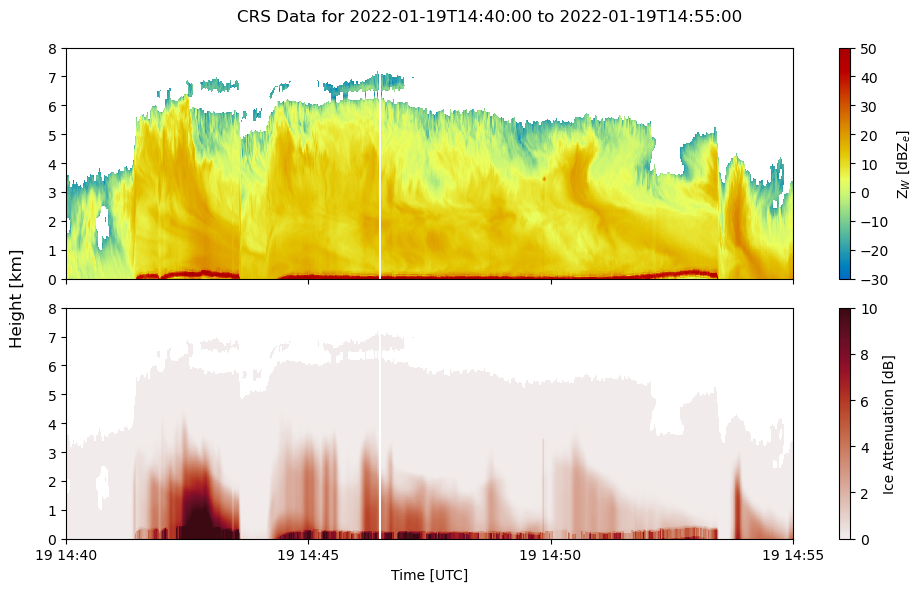

In [8]:
# generate a convient time-height meshgrid for plotting
X, Y = xsection_grid(
    np.tile(np.atleast_2d(crs.data['time']), (len(crs.data['range']), 1)), # 2D time
    crs.data['height'] / 1000. # 2D height in km
)

# plot the corrected Z and the Z difference
fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10,6))

# Z_W (corrected)
ax = axs[0]
plt1 = ax.pcolormesh(
    X, Y, crs.data['dbz'], vmin=-30, vmax=50, cmap='radar_HomeyerRainbow'
)
cb = fig.colorbar(plt1, ax=ax)
cb.set_label('Z$_{W}$ [dBZ$_e$]')

# Z difference (corrected - attenuated; effectively ice attenuation)
ax = axs[1]
plt2 = ax.pcolormesh(
    X, Y, crs.data['dbz'] - crs_atten.data['dbz'],
    vmin=0, vmax=10, cmap=cmap_db
)
cb = fig.colorbar(plt2, ax=ax)
cb.set_label('Ice Attenuation [dB]')

plt.suptitle(f'CRS Data for {str(start)} to {str(end)}')
fig.supylabel('Height [km]')
plt.xlabel('Time [UTC]')
plt.ylim(0, 8)

plt.tight_layout()
plt.show()

Finally plot Z$_{W}$, Z$_{Ka}$ and the DFR.

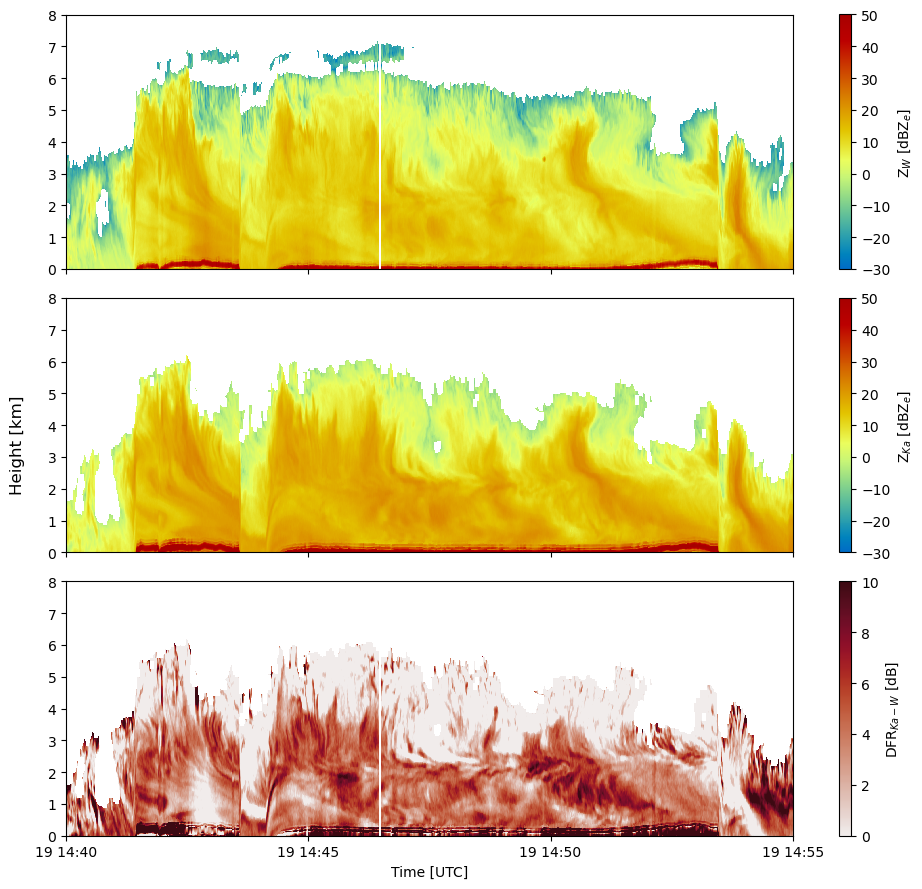

In [9]:
# generate a convient time-height meshgrid for plotting
X, Y = xsection_grid(
    np.tile(
        np.atleast_2d(hiwrap.data['time']),
        (len(hiwrap.data['range']), 1)
    ), # 2D time
    crs.data['height'] / 1000. # 2D height in km
)

fig, axs = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(10,9))

# Z_W (corrected)
ax = axs[0]
plt1 = ax.pcolormesh(
    X, Y, crs.data['dbz'], vmin=-30, vmax=50, cmap='radar_HomeyerRainbow'
)
cb = fig.colorbar(plt1, ax=ax)
cb.set_label('Z$_{W}$ [dBZ$_e$]')

# Z_Ka
ax = axs[1]
plt2 = ax.pcolormesh(
    X, Y, hiwrap.data['dbz_ka'], vmin=-30, vmax=50, cmap='radar_HomeyerRainbow'
)
cb = fig.colorbar(plt2, ax=ax)
cb.set_label('Z$_{Ka}$ [dBZ$_e$]')

# Z difference (corrected - attenuated; effectively ice attenuation)
ax = axs[2]
plt3 = ax.pcolormesh(
    X, Y, hiwrap.data['dbz_ka'] - crs.data['dbz'],
    vmin=0, vmax=10, cmap=cmap_db
)
cb = fig.colorbar(plt3, ax=ax)
cb.set_label('DFR$_{Ka-W}$ [dB]')

fig.supylabel('Height [km]')
plt.xlabel('Time [UTC]')
plt.ylim(0, 8)

plt.tight_layout()
plt.show()